In [1]:
# import kde
import pycisTopic
import glob
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import multiprocess as mp
from multiprocess import Pool
import pprint as pp


def histogram(array, nbins=100):
    """
    Draw histogram from distribution and identify centers.
    Parameters
    ---------
    array: `class::np.array`
            Scores distribution
    nbins: int
            Number of bins to use in the histogram
    Return
    ---------
    float
            Histogram values and bin centers.
    """
    array = array.ravel().flatten()
    hist, bin_edges = np.histogram(array, bins=nbins, range=None)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    return hist, bin_centers


def threshold_otsu(array, nbins=100, min_value=100):
    """
    Apply Otsu threshold on topic-region distributions [Otsu, 1979].
    Parameters
    ---------
    array: `class::np.array`
            Array containing the region values for the topic to be binarized.
    nbins: int
            Number of bins to use in the binarization histogram
    Return
    ---------
    float
            Binarization threshold.
    Reference
    ---------
    Otsu, N., 1979. A threshold selection method from gray-level histograms. IEEE transactions on systems, man, and
    cybernetics, 9(1), pp.62-66.
    """
    array = array[(array >= min_value)]
    hist, bin_centers = histogram(array, nbins)
    hist = hist.astype(float)
    # Class probabilities for all possible thresholds
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    # Class means for all possible thresholds
    mean1 = np.cumsum(hist * bin_centers) / weight1
    mean2 = (np.cumsum((hist * bin_centers)[::-1]) / weight2[::-1])[::-1]
    # Clip ends to align class 1 and class 2 variables:
    # The last value of ``weight1``/``mean1`` should pair with zero values in
    # ``weight2``/``mean2``, which do not exist.
    variance12 = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2
    idx = np.argmax(variance12)
    threshold = bin_centers[:-1][idx]
    mean_selected = np.median(array[(array >= threshold)])
    score = np.sqrt(max(variance12)) / mean_selected
    return threshold, score

In [2]:
%load_ext lab_black

In [3]:
!pwd

/lustre1/project/stg_00090/scatac_benchmark/public_4_cistopic_consensus


In [4]:
os.chdir("/lustre1/project/stg_00090/scatac_benchmark/public_4_cistopic_consensus")

In [8]:
metadata_bc_pkl_list = sorted(glob.glob("cistopic_qc_out/*metadata_bc.pkl"))
metadata_bc_pkl_path_dict = {}
for metadata_bc_pkl_path in metadata_bc_pkl_list:
    sample = metadata_bc_pkl_path.split("/")[-1].split(".")[0]
    metadata_bc_pkl_path_dict[sample] = metadata_bc_pkl_path

metadata_bc_pkl_path_dict

{'BIO_ddseq_m1c1': 'cistopic_qc_out/BIO_ddseq_m1c1.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c2': 'cistopic_qc_out/BIO_ddseq_m1c2.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c3': 'cistopic_qc_out/BIO_ddseq_m1c3.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c4': 'cistopic_qc_out/BIO_ddseq_m1c4.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c5': 'cistopic_qc_out/BIO_ddseq_m1c5.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c6': 'cistopic_qc_out/BIO_ddseq_m1c6.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c7': 'cistopic_qc_out/BIO_ddseq_m1c7.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m1c8': 'cistopic_qc_out/BIO_ddseq_m1c8.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m2c1': 'cistopic_qc_out/BIO_ddseq_m2c1.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m2c2': 'cistopic_qc_out/BIO_ddseq_m2c2.FULL.fragments.tsv.gz__metadata_bc.pkl',
 'BIO_ddseq_m2c3': 'cistopic_qc_out/BIO_ddseq_m2c3.FULL.fragments.tsv.gz__metada

In [9]:
standard_min_x_val = 100
standard_min_y_val = 1
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for metadata_bc_pkl_path in sorted(metadata_bc_pkl_path_dict.keys()):
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    tech = sample.split('_')[1]
    if tech == "ddseq":
        if "BIO_ddseq_1.FULL" in sample:
            min_otsu_frags_dict[sample] = 600
        else:
            min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = standard_min_x_val

    if tech == "s3atac":
        min_otsu_tss_dict[sample] = 0
    else:
        min_otsu_tss_dict[sample] = standard_min_y_val


In [12]:
list(metadata_bc_pkl_path_dict.keys())

['BIO_ddseq_m1c1',
 'BIO_ddseq_m1c2',
 'BIO_ddseq_m1c3',
 'BIO_ddseq_m1c4',
 'BIO_ddseq_m1c5',
 'BIO_ddseq_m1c6',
 'BIO_ddseq_m1c7',
 'BIO_ddseq_m1c8',
 'BIO_ddseq_m2c1',
 'BIO_ddseq_m2c2',
 'BIO_ddseq_m2c3',
 'BIO_ddseq_m2c4',
 'OHS_s3atac_mouse',
 'TXG_10xmultiome_e18mousebrainfresh',
 'TXG_10xv11_adultmousecortexchromiumx',
 'TXG_10xv1_adultmousefresh',
 'TXG_10xv2_adultmousecortex',
 'TXG_10xv2_adultmousecortexchromiumx',
 'VIB_hydrop_1',
 'VIB_hydrop_2',
 'VIB_hydrop_3',
 'VIB_hydrop_4',
 'VIB_hydrop_5']

In [ ]:
{x: x for x in all_order}

{'TXG_10xv1_adultmousefresh': 'TXG_10xv1_adultmousefresh',
 'TXG_10xv11_adultmousecortexchromiumx': 'TXG_10xv11_adultmousecortexchromiumx',
 'TXG_10xv2_adultmousecortex': 'TXG_10xv2_adultmousecortex',
 'TXG_10xv2_adultmousecortexchromiumx': 'TXG_10xv2_adultmousecortexchromiumx',
 'TXG_10xmultiome_e18mousebrainfresh': 'TXG_10xmultiome_e18mousebrainfresh',
 'BIO_ddseq_m1c1': 'BIO_ddseq_m1c1',
 'BIO_ddseq_m1c2': 'BIO_ddseq_m1c2',
 'BIO_ddseq_m1c3': 'BIO_ddseq_m1c3',
 'BIO_ddseq_m1c4': 'BIO_ddseq_m1c4',
 'BIO_ddseq_m1c5': 'BIO_ddseq_m1c5',
 'BIO_ddseq_m1c6': 'BIO_ddseq_m1c6',
 'BIO_ddseq_m1c7': 'BIO_ddseq_m1c7',
 'BIO_ddseq_m1c8': 'BIO_ddseq_m1c8',
 'BIO_ddseq_m2c1': 'BIO_ddseq_m2c1',
 'BIO_ddseq_m2c2': 'BIO_ddseq_m2c2',
 'BIO_ddseq_m2c3': 'BIO_ddseq_m2c3',
 'BIO_ddseq_m2c4': 'BIO_ddseq_m2c4',
 'OHS_s3atac_mouse': 'OHS_s3atac_mouse',
 'VIB_hydrop_1': 'VIB_hydrop_1',
 'VIB_hydrop_2': 'VIB_hydrop_2',
 'VIB_hydrop_3': 'VIB_hydrop_3',
 'VIB_hydrop_4': 'VIB_hydrop_4',
 'VIB_hydrop_5': 'VIB_hydr

In [21]:
all_order = [
    "TXG_10xv1_adultmousefresh",
    "TXG_10xv11_adultmousecortexchromiumx",
    "TXG_10xv2_adultmousecortex",
    "TXG_10xv2_adultmousecortexchromiumx",
    "TXG_10xmultiome_e18mousebrainfresh",
    "BIO_ddseq_m1c1",
    "BIO_ddseq_m1c2",
    "BIO_ddseq_m1c3",
    "BIO_ddseq_m1c4",
    "BIO_ddseq_m1c5",
    "BIO_ddseq_m1c6",
    "BIO_ddseq_m1c7",
    "BIO_ddseq_m1c8",
    "BIO_ddseq_m2c1",
    "BIO_ddseq_m2c2",
    "BIO_ddseq_m2c3",
    "BIO_ddseq_m2c4",
    "OHS_s3atac_mouse",
    "VIB_hydrop_1",
    "VIB_hydrop_2",
    "VIB_hydrop_3",
    "VIB_hydrop_4",
    "VIB_hydrop_5",
]

sample_id_ultrashort_alias_dict = {
    "TXG_10xv1_adultmousefresh": "10x v1",
    "TXG_10xv11_adultmousecortexchromiumx": "10x v1.1",
    "TXG_10xv2_adultmousecortex": "10x v2",
    "TXG_10xv2_adultmousecortexchromiumx": "10x v2 (Chromium X)",
    "TXG_10xmultiome_e18mousebrainfresh": "10x Multiome",
    "BIO_ddseq_m1c1": "ddSEQ Mouse 1 sample 1",
    "BIO_ddseq_m1c2": "ddSEQ Mouse 1 sample 2",
    "BIO_ddseq_m1c3": "ddSEQ Mouse 1 sample 3",
    "BIO_ddseq_m1c4": "ddSEQ Mouse 1 sample 4",
    "BIO_ddseq_m1c5": "ddSEQ Mouse 1 sample 5",
    "BIO_ddseq_m1c6": "ddSEQ Mouse 1 sample 6",
    "BIO_ddseq_m1c7": "ddSEQ Mouse 1 sample 7",
    "BIO_ddseq_m1c8": "ddSEQ Mouse 1 sample 8",
    "BIO_ddseq_m2c1": "ddSEQ Mouse 2 sample 1",
    "BIO_ddseq_m2c2": "ddSEQ Mouse 2 sample 2",
    "BIO_ddseq_m2c3": "ddSEQ Mouse 2 sample 3",
    "BIO_ddseq_m2c4": "ddSEQ Mouse 2 sample 4",
    "OHS_s3atac_mouse": "s3-ATAC",
    "VIB_hydrop_1": "HyDrop 1",
    "VIB_hydrop_2": "HyDrop 2",
    "VIB_hydrop_3": "HyDrop 3",
    "VIB_hydrop_4": "HyDrop 4",
    "VIB_hydrop_5": "HyDrop 5",
}

tech_color_palette = {
    "10xv2": "#1b9e77",
    "10xv1": "#d95f02",
    "10xv11": "#7570b3",
    "10xmultiome": "#e7298a",
    "mtscatac": "#66a61e",
    "ddseq": "#e6ab02",
    "s3atac": "#a6761d",
    "hydrop": "#666666",
}

In [22]:
!cat kde_intermediate.py

cat: kde_intermediate.py: No such file or directory


In [35]:
standard_min_x_val = 100
standard_min_y_val = 0.5
min_otsu_frags_dict = {}
min_otsu_tss_dict = {}
for metadata_bc_pkl_path in sorted(metadata_bc_pkl_path_dict.keys()):
    sample = metadata_bc_pkl_path.split("/")[-1].split("__metadata_bc.pkl")[0]
    tech = sample.split("_")[1]
    if tech == "ddseq":
        min_otsu_frags_dict[sample] = 300
    elif tech == "hydrop":
        min_otsu_frags_dict[sample] = 300
    else:
        min_otsu_frags_dict[sample] = standard_min_x_val

    if tech == "s3atac":
        min_otsu_tss_dict[sample] = 0
    else:
        min_otsu_tss_dict[sample] = standard_min_y_val

selected_barcodes/TXG_10xv1_adultmousefresh_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out/TXG_10xv1_adultmousefresh.FULL.fragments.tsv.gz__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/TXG_10xv11_adultmousecortexchromiumx_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out/TXG_10xv11_adultmousecortexchromiumx.FULL.fragments.tsv.gz__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/TXG_10xv2_adultmousecortex_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out/TXG_10xv2_adultmousecortex.FULL.fragments.tsv.gz__metadata_bc.pkl
	Filtering cells and generating QC plots.
selected_barcodes/TXG_10xv2_adultmousecortexchromiumx_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading cistopic_qc_out/TXG_10xv2_adultmousecortexchromiumx.FULL.frag

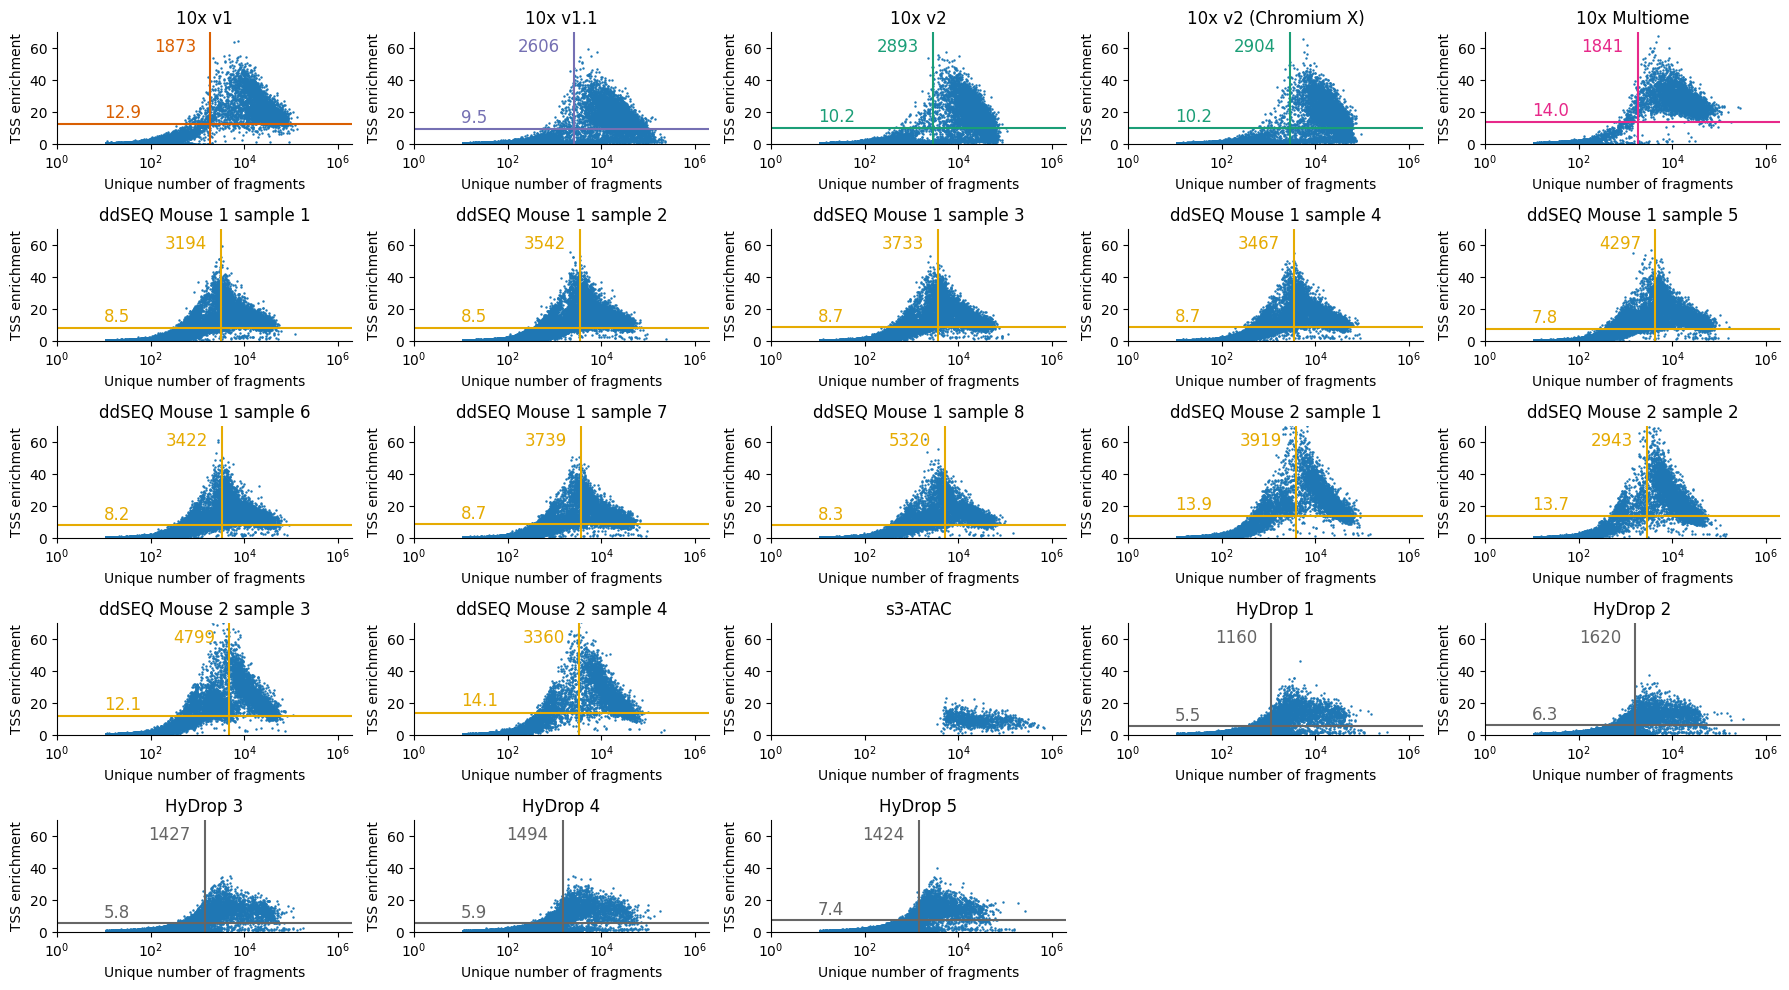

In [38]:
fig, axes = plt.subplots(5, 5, figsize=(18, 10))  # , sharex=True, sharey=True)
axes = axes.flatten()


for sample in all_order:
    tech = sample.split("_")[1]
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    print(f"{pkl_path} bc passing filters does not exist yet, generating...")
    print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)

    print(f"\tFiltering cells and generating QC plots.")
    if not sample in min_otsu_frags_dict.keys():
        print(
            f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
        )
        min_x_val = standard_min_x_val
        min_y_val = standard_min_y_val
    else:
        min_x_val = min_otsu_frags_dict[sample]
        min_y_val = min_otsu_tss_dict[sample]

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
    x_threshold_log, x_score = threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_x_val)
    )
    x_threshold = 10**x_threshold_log

    # cell_filtering_quality_score_df.at[sample, "frag_filter_score2"] = x_score2

    y_arr = metadata_bc_df["TSS_enrichment"]
    y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # cell_filtering_quality_score_df.at[sample, "TSS_filter_score2"] = y_score2

    ax = axes[all_order.index(sample)]
    sns.scatterplot(
        data=metadata_bc_df,
        x="Unique_nr_frag",
        y="TSS_enrichment",
        # hue="consensus_cell_type",
        # palette=cell_type_color_dict,
        s=3,
        linewidth=0,
        ax=ax,
    )
    if not "s3" in sample:
        ax.hlines(y=y_threshold, xmin=1, xmax=3000000, color=tech_color_palette[tech])
        ax.vlines(x=x_threshold, ymin=0, ymax=100, color=tech_color_palette[tech])

        ax.text(
            x=x_threshold * 0.5,
            y=55,
            s=str(int(x_threshold)),
            ha="right",
            va="bottom",
            color=tech_color_palette[tech],
            fontsize=12,
        )
        ax.text(
            x=10,
            y=y_threshold * 1.1,
            s=str(round(y_threshold, 1)),
            ha="left",
            va="bottom",
            color=tech_color_palette[tech],
            fontsize=12,
        )

    sns.despine(ax=ax, top=True, right=True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xscale("log")
    # ax.set_yscale('log')
    ax.set_xlim([1, 2000000])
    ax.set_ylim([0, 70])

    ax.set_xlabel("Unique number of fragments")
    ax.set_ylabel("TSS enrichment")
    # ax.text(
    #     x=10,
    #     y=70,
    #     s=f"{sample_id_ultrashort_alias_dict[sample]}",
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    # )
    ax.set_title(f"{sample_id_ultrashort_alias_dict[sample]}")
plt.tight_layout()
axes[-1].remove()
axes[-2].remove()

plt.tight_layout()
plt.savefig("plots_qc/all_tss_nokde.png", dpi=600)

In [56]:
density_paths = {
    x.split("/")[-1].split("__")[0]: x
    for x in sorted(glob.glob("intermediate_df/*TSS*"))
}
density_paths

{'BIO_ddseq_m1c1': 'intermediate_df/BIO_ddseq_m1c1__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c2': 'intermediate_df/BIO_ddseq_m1c2__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c3': 'intermediate_df/BIO_ddseq_m1c3__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c4': 'intermediate_df/BIO_ddseq_m1c4__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c5': 'intermediate_df/BIO_ddseq_m1c5__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c6': 'intermediate_df/BIO_ddseq_m1c6__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c7': 'intermediate_df/BIO_ddseq_m1c7__TSS_enrichment_density.csv',
 'BIO_ddseq_m1c8': 'intermediate_df/BIO_ddseq_m1c8__TSS_enrichment_density.csv',
 'BIO_ddseq_m2c1': 'intermediate_df/BIO_ddseq_m2c1__TSS_enrichment_density.csv',
 'BIO_ddseq_m2c2': 'intermediate_df/BIO_ddseq_m2c2__TSS_enrichment_density.csv',
 'BIO_ddseq_m2c3': 'intermediate_df/BIO_ddseq_m2c3__TSS_enrichment_density.csv',
 'BIO_ddseq_m2c4': 'intermediate_df/BIO_ddseq_m2c4__TSS_enrichment_density.csv',
 'OHS_s3atac_mouse': 'interm

selected_barcodes/TXG_10xv1_adultmousefresh_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/TXG_10xv1_adultmousefresh__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/TXG_10xv11_adultmousecortexchromiumx_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/TXG_10xv11_adultmousecortexchromiumx__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/TXG_10xv2_adultmousecortex_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/TXG_10xv2_adultmousecortex__TSS_enrichment_density.csv
	Filtering cells and generating QC plots.
selected_barcodes/TXG_10xv2_adultmousecortexchromiumx_bc_passing_filters_otsu.pkl bc passing filters does not exist yet, generating...
	Loading intermediate_df/TXG_10xv2_adultmousecortexchromiumx__TSS_enrichment_density.csv
	Filtering cel

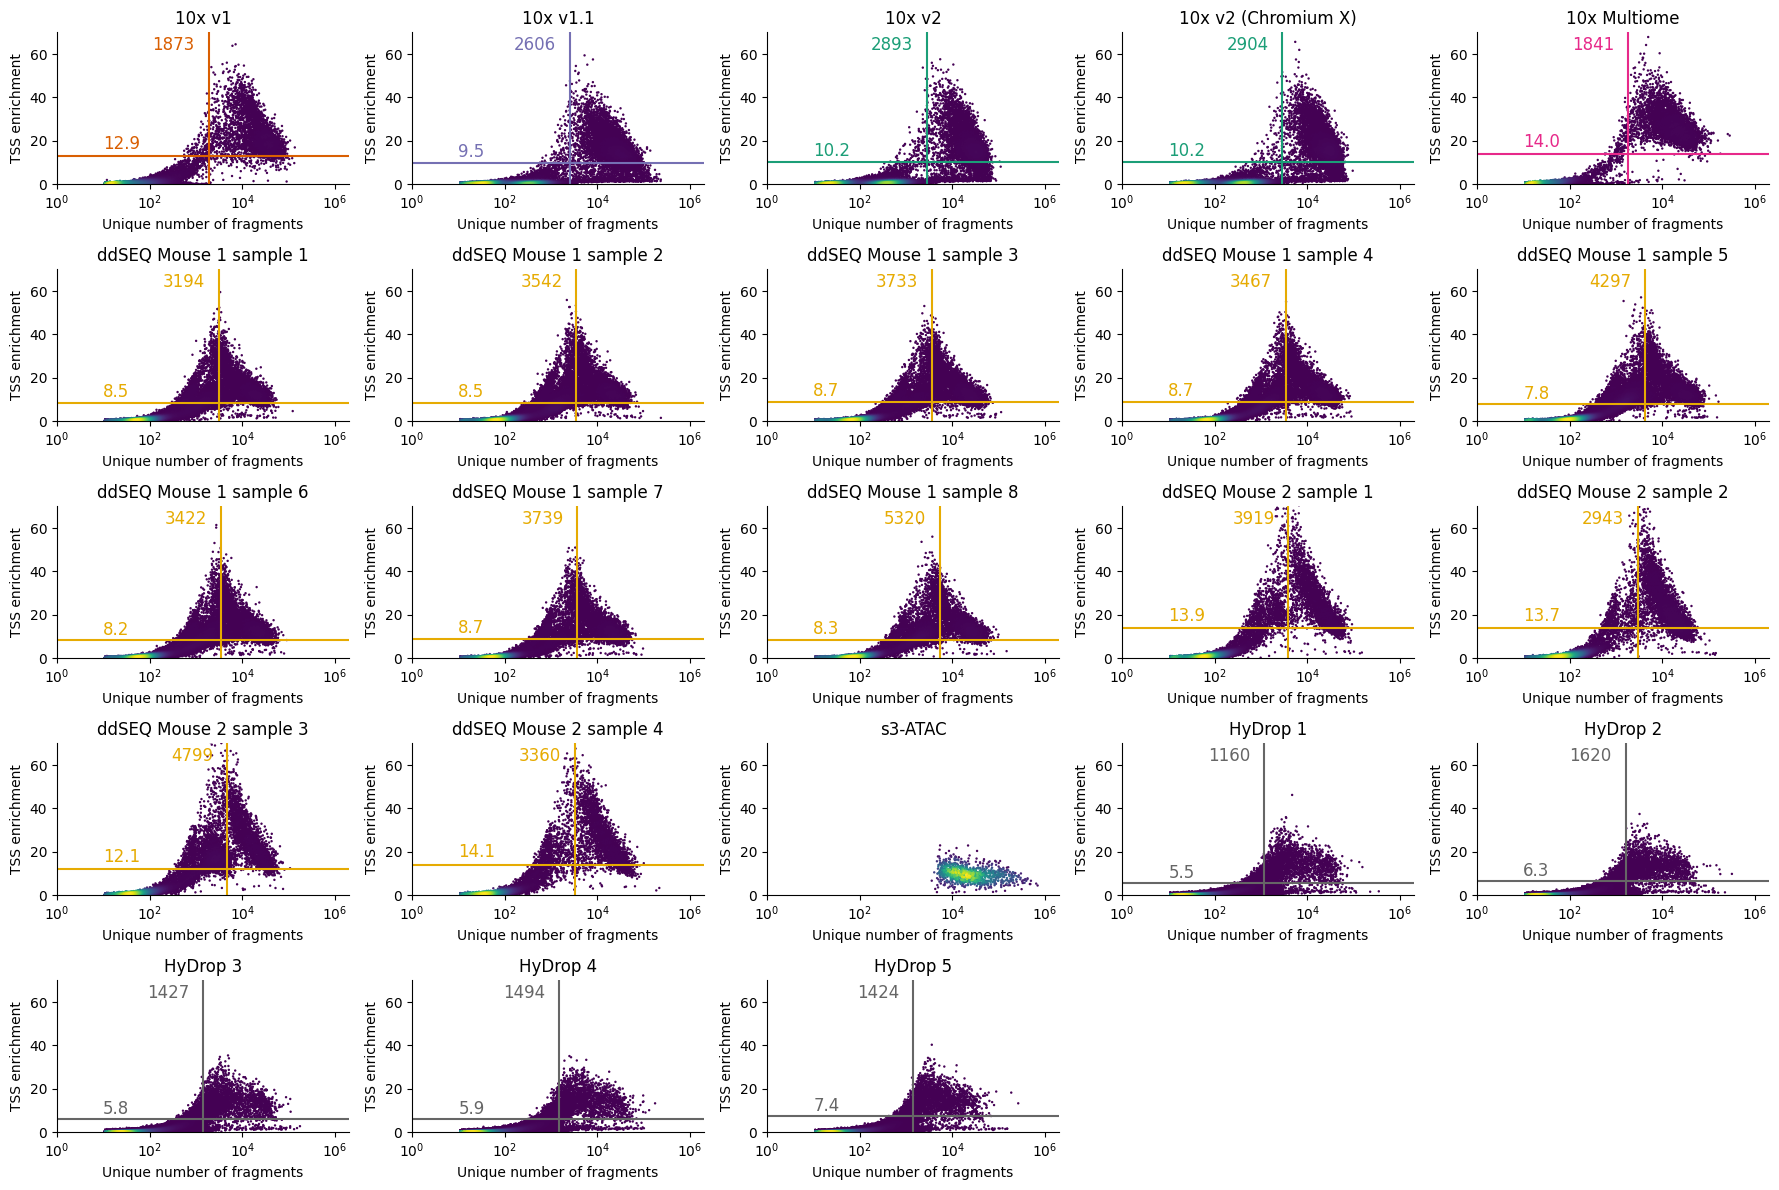

In [61]:
fig, axes = plt.subplots(5, 5, figsize=(18, 12))  # , sharex=True, sharey=True)
axes = axes.flatten()


for sample in all_order:
    tech = sample.split("_")[1]
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    print(f"{pkl_path} bc passing filters does not exist yet, generating...")
    print(f"\tLoading {density_paths[sample]}")
    metadata_bc_df = pd.read_csv(density_paths[sample], header=None, index_col=0)
    metadata_bc_df.columns = ["Unique_nr_frag", "TSS_enrichment", "z"]

    print(f"\tFiltering cells and generating QC plots.")
    if not sample in min_otsu_frags_dict.keys():
        print(
            f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
        )
        min_x_val = standard_min_x_val
        min_y_val = standard_min_y_val
    else:
        min_x_val = min_otsu_frags_dict[sample]
        min_y_val = min_otsu_tss_dict[sample]

    # calculate thresholds using a double otsu strategy:
    # first we calculate an otsu threshold using a minimum of 10 fragments
    # then, this otsu threshold is used as the minimum for the second iteration

    x_arr = np.log10(metadata_bc_df["Unique_nr_frag"])
    x_threshold_log, x_score = threshold_otsu(
        x_arr, nbins=5000, min_value=np.log10(min_x_val)
    )
    x_threshold = 10**x_threshold_log

    # cell_filtering_quality_score_df.at[sample, "frag_filter_score2"] = x_score2

    y_arr = metadata_bc_df["TSS_enrichment"]
    y_threshold, y_score = threshold_otsu(y_arr, nbins=5000, min_value=min_y_val)

    # cell_filtering_quality_score_df.at[sample, "TSS_filter_score2"] = y_score2

    ax = axes[all_order.index(sample)]
    sns.scatterplot(
        data=metadata_bc_df,
        x="Unique_nr_frag",
        y="TSS_enrichment",
        hue="z",
        palette="viridis",
        # palette=cell_type_color_dict,
        s=3,
        linewidth=0,
        ax=ax,
    )
    if not "s3" in sample:

        ax.hlines(y=y_threshold, xmin=1, xmax=3000000, color=tech_color_palette[tech])
        ax.vlines(x=x_threshold, ymin=0, ymax=100, color=tech_color_palette[tech])

        ax.text(
            x=x_threshold * 0.5,
            y=60,
            s=str(int(x_threshold)),
            ha="right",
            va="bottom",
            color=tech_color_palette[tech],
            fontsize=12,
        )
        ax.text(
            x=10,
            y=y_threshold * 1.1,
            s=str(round(y_threshold, 1)),
            ha="left",
            va="bottom",
            color=tech_color_palette[tech],
            fontsize=12,
        )

    sns.despine(ax=ax, top=True, right=True)
    # ax.set_xticklabels([])
    # ax.set_yticklabels([])
    ax.set_xscale("log")
    # ax.set_yscale('log')
    ax.set_xlim([1, 2000000])
    ax.set_ylim([0, 70])

    ax.set_xlabel("Unique number of fragments")
    ax.set_ylabel("TSS enrichment")
    # ax.text(
    #     x=10,
    #     y=70,
    #     s=f"{sample_id_ultrashort_alias_dict[sample]}",
    #     ha="left",
    #     va="bottom",
    #     color=tech_color_palette[tech],
    # )
    ax.set_title(f"{sample_id_ultrashort_alias_dict[sample]}")
    ax.legend().remove()

plt.tight_layout()
axes[-1].remove()
axes[-2].remove()

plt.savefig("plots_qc/all_tss_kde.png", dpi=600)